In [239]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage.io import imread,imshow
from skimage.transform import  resize
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, concatenate
from keras import Sequential, Model
from keras.metrics import  Precision, Recall, AUC
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score
from scipy.signal import convolve2d
from os.path import join
from os import listdir
import pickle

from keras import backend as K
from keras.utils.generic_utils import get_custom_objects

In [240]:
def noisy(image, noisy_rate = 0.1):
    s_vs_p = 0.5
    
    out = np.copy(image)
    mask = np.zeros(image.shape)
    # Salt mode
    num_salt = np.ceil(noisy_rate * image.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, int(num_salt))
          for i in image.shape]
    
    mask[tuple(coords)] = 1
    out[tuple(coords)] = 1

    # Pepper mode
    num_pepper = np.ceil(noisy_rate* image.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i - 1, int(num_pepper))
          for i in image.shape]
    
    mask[tuple(coords)] = 1
    out[tuple(coords)] = 0
    
    return out, mask

In [241]:
def MSE(img1, img2):
    shape = np.array(img1.shape).prod()
    res = ((img1-img2)**2).sum()/shape
    if (res == 0):
        raise ValueError
    else:
        return res

def compute_psnr(img_pred, img_gt):
    img_pred = img_pred.astype('float64')
    img_gt = img_gt.astype('float64')
    return 10*np.log10(img_gt.max()**2/MSE(img_pred, img_gt))

In [242]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score


get_custom_objects().update({'dice_coef': dice_coef })

In [243]:
def get_model(size, start_neurons=8):
    input_layer = Input(size+(1,))

    conv1 = Conv2D(start_neurons*1,(3,3),activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons*1,(3,3),activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(start_neurons*2,(3,3),activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons*2,(3,3),activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(start_neurons*4,(3,3),activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons*4,(3,3),activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(start_neurons*8,(3,3),activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons*8,(3,3),activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons*16,(3,3),activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons*16,(3,3),activation="relu", padding="same")(convm)

    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons*8,(3,3),activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons*8,(3,3),activation="relu", padding="same")(uconv4)

    deconv3 = Conv2DTranspose(start_neurons*4,(3,3),strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons*4,(3,3),activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons*4,(3,3),activation="relu", padding="same")(uconv3)

    deconv2 = Conv2DTranspose(start_neurons*2,(3,3),strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons*2,(3,3),activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons*2,(3,3),activation="relu", padding="same")(uconv2)

    deconv1 = Conv2DTranspose(start_neurons*1,(3,3),strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons*1,(3,3),activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons*1,(3,3),activation="relu", padding="same")(uconv1)

    output_layer = Conv2D(1,(1,1), padding="same", activation="sigmoid")(uconv1)
    
    model = Model(input_layer, output_layer)

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'dice_coef', Precision(), Recall(), AUC()])
    return model

In [244]:
def get_data(size, path, amount=5012, noisy_rate=0.1):
    shape = (amount,)+size
    X_train = np.empty(shape)
    y_train = np.empty(shape)
    orig = np.empty(shape)
    
    files = listdir(path)
    amount = min(len(files), amount)
    
    for i,file in enumerate(files[:amount]):
        img = resize(imread(join(path, file), as_gray=True), size)
        X_train[i], y_train[i], orig[i] = noisy(img, noisy_rate=noisy_rate) + (img,)
         
        
    return X_train.reshape(shape+(1,)), y_train.reshape(shape+(1,)), orig.reshape(shape+(1,))

In [365]:
path = 'data/VOC2007/JPEGImages'
size = (240,240)

X,y, orig = get_data(size, path, amount=10, noisy_rate=0.05)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, shuffle=False)

In [246]:
model = get_model(size)
model.load_weights('detection.hdf5')

In [352]:
def get_weights(size, noise_mask, center, radius=2, sigma=1.1):
    Y, X = np.ogrid[:size[0], :size[1]]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    mask[center] = 0
    mask = mask * np.where(noise_mask, 0, 1)
    
    
#     dist_from_center = np.where(mask, dist_from_center, 0)
    temp = 1/(np.exp(5*dist_from_center))
    temp = np.where(mask, temp, 0)
    a = temp.sum()
    weights = temp / (a + 1e-9)
    
    return weights

In [360]:
def delete_noise(noised_img, noise_mask):
    
    def f(center):
        return get_weights(noised_img.shape, noise_mask, center)
    
    if len(noised_img.shape) == 3:
        noised_img = noised_img[:,:,0]
        
    if len(noise_mask.shape) == 3:
        noise_mask = noise_mask[:,:,0]
    
    noise_free = np.where(noise_mask, 0, noised_img)
    x,y = np.where(noise_mask)
    
    weights = np.array(list(map(f, zip(x,y))))
    print(weights[0][:20,:4])
    print(weights[0][x[0],y[0]])
    for i,j, weight in zip(x,y, weights):
        noise_free[i,j] = (noise_free*weight).sum()
    return noise_free

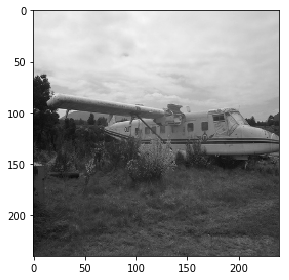

In [376]:
orig_ = orig[1].reshape(size)
imshow(orig_)

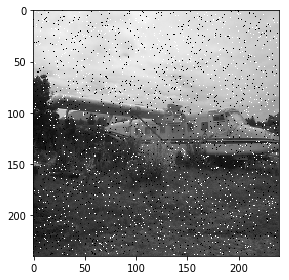

In [377]:
noised = X_train[1].reshape(size)
imshow(noised)

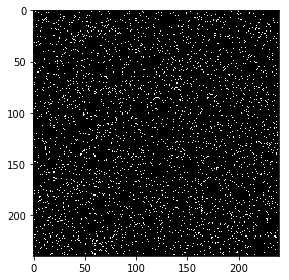

In [378]:
mask = y_train[1].reshape(size)
imshow(mask)

In [380]:
denoised = delete_noise(noised, mask)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [4.44205154e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [6.59258903e-03 8.31003171e-04 0.00000000e+00 0.00000000e+00]
 [9.78426964e-01 6.59258903e-03 4.44205154e-05 0.00000000e+00]
 [6.59258903e-03 8.31003171e-04 0.00000000e+00 0.00000000e+00]
 [4.44205154e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.000000

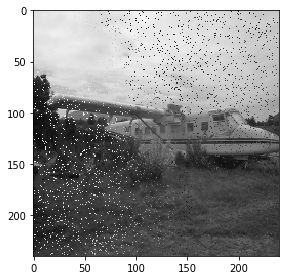

In [381]:
imshow(denoised)

In [384]:
compute_psnr(denoised, noised)

17.816462692660423

In [260]:
with open('stats.pickle', 'rb') as f:
    stats = pickle.load(f)

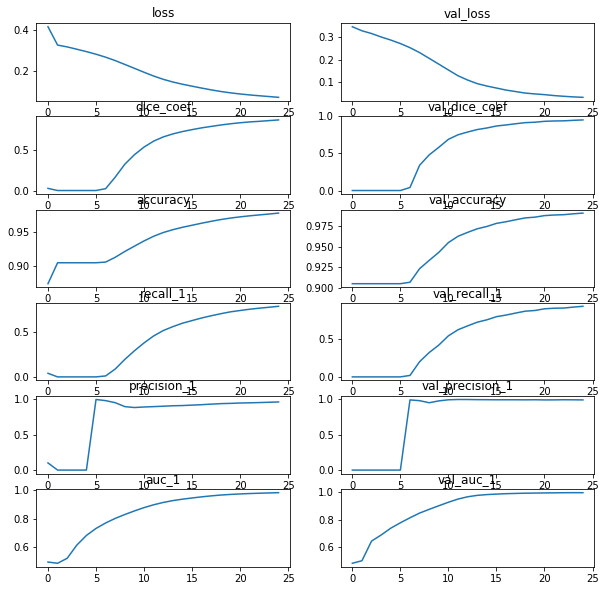

In [277]:
fig, axes = plt.subplots(6,2, figsize=(10,10))

metrics = ['loss', 'val_loss', 'dice_coef', 'val_dice_coef', 'accuracy', 'val_accuracy', 
           'recall_1', 'val_recall_1', 'precision_1', 'val_precision_1', 'auc_1', 'val_auc_1']

for i, metric in enumerate(metrics):
    axes[i // 2, i % 2].plot(stats[metric])
    axes[i // 2, i % 2].title.set_text(metric)
    axes[i // 2, i % 2].grid = True

In [364]:
for metric in metrics:
    print(metric,':',stats[metric][-1])

loss : 0.07424627244472504
val_loss : 0.03225557878613472
dice_coef : 0.8680146336555481
val_dice_coef : 0.9527731537818909
accuracy : 0.9770282506942749
val_accuracy : 0.9913765788078308
recall_1 : 0.7914287447929382
val_recall_1 : 0.9214760661125183
precision_1 : 0.9600878953933716
val_precision_1 : 0.9869499802589417
auc_1 : 0.980644166469574
val_auc_1 : 0.9969896674156189
